<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/Transliterate_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.embeddings import Embedding

import tensorflow as tf
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

In [2]:
%cd /content/drive/MyDrive/Colab/Transliterate/

/content/drive/MyDrive/Colab/Transliterate


In [3]:
%ls

affidavits.csv                 model.png
hi.translit.sampled.train.tsv  model_v1.h5
model.h5                       players_with_hindi_names.json
model_plot_dec.png


# Preprocessing Data

## load affidavits dataset


In [4]:
affidavits_df = pd.read_csv('affidavits.csv')

In [5]:
affidavits_df.head()

,address,affidavit_filename_with_unique_id,age,application_uploaded,assembly_constituency,current_status,dropdown_value,fathers_or_husbands_name_english,fathers_or_husbands_name_hindi,name,name_english,name_hindi,party_name,photo_filename_with_unique_id,photo_url,state,unique_id,url
0,"O/5, BANKIM MUKHERJEE SARANI, DURGAPUR COLONY,...",NaN,57,"7th April, 2021",Rashbehari,NaN,NaN,LATE SUBODH CHANDRA DAS,प्रयात सुबोध चन्द्र दास,SWAPAN DAS,SWAPAN DAS,स्वपन दास,Bahujan Mukti Party,NaN,NaN,West Bengal,1,NaN
1,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,2,NaN
2,"Vill- Debidaspur, P.O.- Kankuria, P.S.- Samser...",NaN,60,"26th April, 2021",Samserganj,NaN,NaN,Late Nur Mohammad Biswas,मृत नूर महम्मद बिश्वास,Zaidur Rahaman,Zaidur Rahaman,जैदुर रहमान,Indian National Congress,NaN,NaN,West Bengal,3,NaN
3,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,4,NaN
4,"VILL-FULBARI, P.O-KAMLABARI, P.S-ENGLISH BAZAR...",NaN,42,"6th April, 2021",Manikchak,NaN,NaN,LT. ALI MOHAMMAD,स्वर्गीय आली महममद,ALAM MOTTAKIN,ALAM MOTTAKIN,आलम मोत्ताकिन,Indian National Congress,NaN,NaN,West Bengal,5,NaN


In [6]:
af_df = affidavits_df[['fathers_or_husbands_name_hindi', 'fathers_or_husbands_name_english', 'name_hindi', 'name_english']]

In [7]:
# split and merge
input_target_df = pd.concat([
                    af_df[['fathers_or_husbands_name_hindi','fathers_or_husbands_name_english']].rename(columns={"fathers_or_husbands_name_hindi": "hindi", "fathers_or_husbands_name_english": "english"}), 
                    af_df[['name_hindi','name_english']].rename(columns={"name_hindi": "hindi", "name_english": "english"})
                  ], ignore_index=True)

In [8]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


## load cricket dataset

In [9]:
cricket_df = pd.read_json('players_with_hindi_names.json')

In [10]:
cricket_df.head()

,id,hindi_name,hindi_long_name,english_name,gender,date_of_birth,country_id,slug
0,90143,आर गुरबाज़,रहमानउल्लाह गुरबाज़,Rahmanullah Gurbaz,M,"{'year': 2001, 'month': 11, 'date': 28}",40,rahmanullah-gurbaz
1,54018,एम रिज़वान,मोहम्मद रिज़वान,Mohammad Rizwan,M,"{'year': 1992, 'month': 6, 'date': 1}",7,mohammad-rizwan
2,47686,एस मक़सूद,सोहेब मक़सूद,Sohaib Maqsood,M,"{'year': 1987, 'month': 4, 'date': 15}",7,sohaib-maqsood
3,53649,आर आर रुसो,राइली रुसो,"Rossouw, RR",M,"{'year': 1989, 'month': 10, 'date': 9}",3,rilee-rossouw
4,72393,एस हेटमायर,शिमरॉन हेटमायर,"Hetmyer, SO",M,"{'year': 1996, 'month': 12, 'date': 26}",4,shimron-hetmyer


In [11]:
input_target_df = pd.concat([
                             input_target_df, 
                             cricket_df[['hindi_long_name', 'english_name']].rename(columns={"hindi_long_name": "hindi", "english_name": "english"}) 
                             ], ignore_index=True)

## load Dakshina Dataset

In [12]:

dakshina_df = pd.read_csv('hi.translit.sampled.train.tsv', sep='\t', names=["hindi", "english", "freq"])

In [13]:
dakshina_df.head()

,hindi,english,freq
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [14]:
input_target_df = pd.concat([
                             input_target_df, 
                             dakshina_df[['hindi', 'english']]
                             ], ignore_index=True)

In [15]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


In [16]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77908 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    72727 non-null  object
 1   english  77906 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [17]:
input_target_df = input_target_df.dropna()

In [18]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72725 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    72725 non-null  object
 1   english  72725 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [19]:
# strip and make lower case
input_target_df['hindi'] = input_target_df['hindi'].str.strip() # hindi has no caps
input_target_df['english'] = input_target_df['english'].str.strip().str.lower()

In [20]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,late subodh chandra das
1,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
2,मृत नूर महम्मद बिश्वास,late nur mohammad biswas
3,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
4,स्वर्गीय आली महममद,lt. ali mohammad


In [21]:
# Strip out any abbreviated names
input_target_df = input_target_df[~input_target_df['english'].str.contains('\.')]
input_target_df = input_target_df[~input_target_df['english'].str.contains(',')]

In [22]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63899 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    63899 non-null  object
 1   english  63899 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [23]:
# drop duplicates
input_target_df = input_target_df.drop_duplicates()

In [24]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55821 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    55821 non-null  object
 1   english  55821 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [25]:
# Remove if target has non-english 
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

input_target_df = input_target_df[input_target_df['english'].apply(isEnglish)]

In [26]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55768 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    55768 non-null  object
 1   english  55768 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [27]:
# append start and end of sequence for target
sos = '^'
eos = '$'

input_target_df['english'] = sos + input_target_df['english'].astype(str) + eos

In [28]:
input_words =  input_target_df['hindi'].tolist()
target_words =  input_target_df['english'].tolist()

In [29]:
print(input_words[0])
print(target_words[0])

प्रयात सुबोध चन्द्र दास
^late subodh chandra das$


In [30]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 55768
Total number of target words 55768


In [31]:
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [32]:
input_vocab, target_vocab = build_vocab(input_words, target_words)

In [33]:
print(f"Total hindi characters {len(input_vocab)}")
print(f"Total english characters {len(target_vocab)}")

Total hindi characters 186
Total english characters 35


In [34]:
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))

In [35]:
input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [36]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [37]:
num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [38]:
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])

In [39]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 55768
Number of unique input tokens: 186
Number of unique output tokens: 35
Max sequence length for inputs: 47
Max sequence length for outputs: 49


In [40]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [41]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")
print(f"decoder target shape {decoder_target_data.shape}")

encoder input shape (55768, 47, 186)
decoder input shape (55768, 49, 35)
decoder target shape (55768, 49, 35)


In [42]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  # for the rest of sentence, mark it as space
  #encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t-1, target_token_index[char]] = 1.0
      # for the rest of sentence, mark it as space
      #decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0

# Define Model

In [43]:
latent_dim = 256  # Latent dimensionality of the encoding space.
EMBEDDING_SIZE = 100

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
print(encoder_inputs.shape)

# Define embedding layer
encoder_embedding = Embedding(num_encoder_tokens, EMBEDDING_SIZE, input_length=max_encoder_seq_length)
encoder_inputs_em = encoder_embedding(encoder_inputs)
print(encoder_inputs_em.shape)

# since embedding layer will add one more dim, we need to flatten last 2 dims
encoder_reshape = Reshape((-1, encoder_inputs_em.shape[2] * encoder_inputs_em.shape[3]))
encoder_inputs_re = encoder_reshape(encoder_inputs_em)
print(encoder_inputs_re.shape)

# Note that LSTM takes only 3 dims, (samples, timesteps, features)
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs_re)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

(None, None, 186)
(None, None, 186, 100)
(None, None, 18600)


In [44]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
print(decoder_inputs.shape)

# Define embeddling layer
decoder_embedding = Embedding(num_decoder_tokens, latent_dim)
decoder_inputs_em = decoder_embedding(decoder_inputs)
print(decoder_inputs_em.shape)

# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder(decoder_inputs_re, initial_state=encoder_states)
print(decoder_outputs.shape)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
print(decoder_outputs.shape)

(None, None, 35)
(None, None, 35, 256)
(None, None, 8960)
(None, None, 256)
(None, None, 35)


In [45]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 186)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 35)]   0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 186, 10 18600       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 35, 256 8960        input_2[0][0]                    
______________________________________________________________________________________________

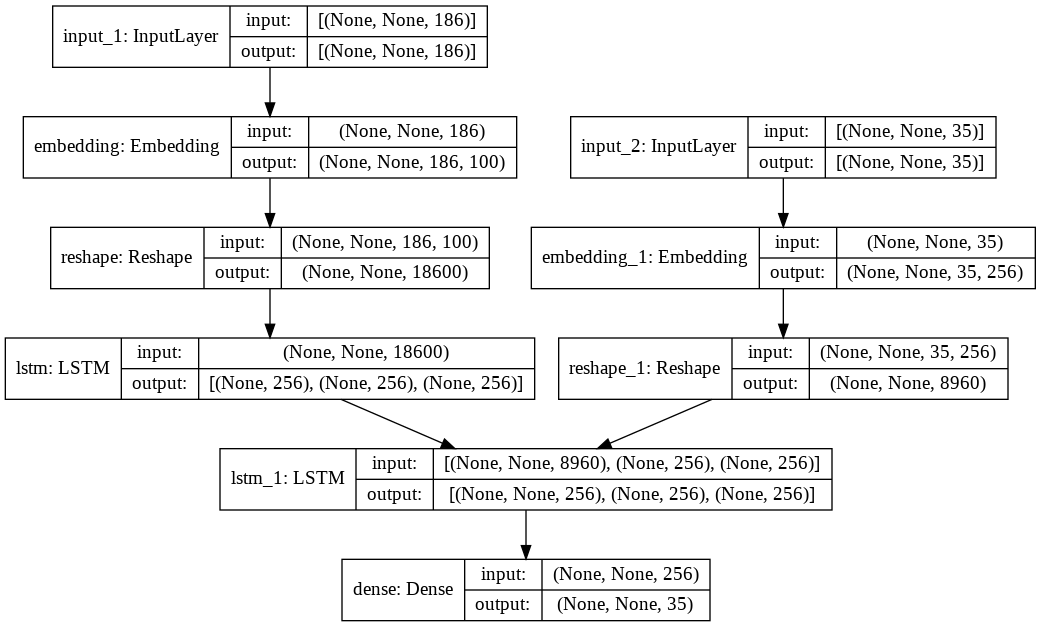

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Train

In [48]:
# edit distance playground
hypothesis = tf.SparseTensor(
            [[0, 0, 0],
             [1, 0, 0],
             [2, 0, 0],
             [3, 0, 0]],
             ["a", "b", "c", "d"],
            (4, 1, 1))

truth = tf.SparseTensor(
            [[0, 0, 0],
             [1, 0, 0],
             [2, 0, 0],
             [3, 0, 0]],
             ["a", "b", "c", "e"],
            (4, 1, 1))

d = tf.edit_distance(hypothesis, truth)
d

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [1.]], dtype=float32)>

In [49]:
# edit distance playground
hypothesis = tf.SparseTensor(
            [[0, 0, 0],
             [1, 0, 0],
             [2, 0, 0],
             [3, 0, 0]],
             [b'a', b'b', b'c', b'd'],
            (4, 1, 1))

truth = tf.SparseTensor(
            [[0, 0, 0],
             [1, 0, 0],
             [2, 0, 0],
             [3, 0, 0]],
             [b'a', b'b', b'c', b'e'],
            (4, 1, 1))

d = tf.edit_distance(hypothesis, truth)
print(d)
print(tf.reduce_sum(d))
distance = tf.reduce_sum(d)
print(distance/truth.shape[0])

tf.Tensor(
[[0.]
 [0.]
 [0.]
 [1.]], shape=(4, 1), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0.25, shape=(), dtype=float32)


In [50]:
def convert_to_chars(batch_tensor):
  # batch, maxlength, vocab_length - ex 64, 49, 35
  # create numpy of above size with ''
  target_data = np.zeros(tuple(batch_tensor.shape.as_list()), dtype='str')
  batch_tensor_list = tf.unstack(batch_tensor)
  for batch_idx in range(len(batch_tensor_list)):
    sentence = tf.unstack(batch_tensor_list[batch_idx])
    for sent_idx in range(len(sentence)):
      char_idx = np.argmax(sentence[sent_idx])
      target_data[batch_idx, sent_idx, char_idx] = reverse_target_char_index[char_idx]
  return tf.convert_to_tensor(target_data, dtype=tf.string)

def calculate_edit_distance(h_batch, t_batch):
  h_batch_list = tf.unstack(h_batch)
  t_batch_list = tf.unstack(t_batch)
  error = 0.0
  for h, t in zip(h_batch_list, t_batch_list):
    # tf.edit_distance requires sparse tensors
    h_sparse = tf.sparse.from_dense(h)
    t_sparse = tf.sparse.from_dense(t)

    distance = tf.edit_distance(h_sparse, t_sparse)
    error += tf.reduce_sum(distance)/t_sparse.shape[0]
  return error

class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """

    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # convert to chars
        y_true_chars = convert_to_chars(y_true)
        y_pred_chars = convert_to_chars(y_pred)
        batch_error = calculate_edit_distance(y_pred_chars, y_true_chars)
        # sum all edit distance error till now
        self.cer_accumulator.assign_add(batch_error)
        # total samples till now 
        self.counter.assign_add(tf.cast(len(y_true), dtype="float32"))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)

In [51]:
# Training
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
initial_learning_rate = 0.001

model_save_filename = "model.h5"

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate), 
    loss='categorical_crossentropy', 
    metrics=['accuracy', CERMetric()], run_eagerly=True)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
# 'LearningRateScheduler' to decay lr 
earlystopping_cb = EarlyStopping(
    monitor="val_CER_metric",
    mode="min",
    verbose=1,
    patience=10, 
    restore_best_weights=True)

mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename, 
    monitor="val_CER_metric", 
    mode="min",
    verbose=1,
    save_best_only=True
)

decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)
lrscheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])

Epoch 1/100
698/698 [==============================] - 752s 1s/step - loss: 0.5612 - accuracy: 0.0456 - CER_metric: 0.9544 - val_loss: 0.4805 - val_accuracy: 0.0359 - val_CER_metric: 0.9641

Epoch 00001: val_CER_metric improved from inf to 0.96412, saving model to model.h5
Epoch 2/100
698/698 [==============================] - 749s 1s/step - loss: 0.5396 - accuracy: 0.0489 - CER_metric: 0.9511 - val_loss: 0.4828 - val_accuracy: 0.0372 - val_CER_metric: 0.9628

Epoch 00002: val_CER_metric improved from 0.96412 to 0.96276, saving model to model.h5
Epoch 3/100
698/698 [==============================] - 750s 1s/step - loss: 0.5380 - accuracy: 0.0537 - CER_metric: 0.9463 - val_loss: 0.4827 - val_accuracy: 0.0388 - val_CER_metric: 0.9612

Epoch 00003: val_CER_metric improved from 0.96276 to 0.96118, saving model to model.h5
Epoch 4/100
698/698 [==============================] - 753s 1s/step - loss: 0.5357 - accuracy: 0.0543 - CER_metric: 0.9457 - val_loss: 0.4793 - val_accuracy: 0.0388 - val

In [52]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'CER_metric', 'val_loss', 'val_accuracy', 'val_CER_metric', 'lr'])


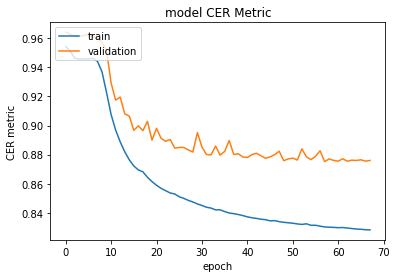

In [55]:
# summarize history for accuracy
plt.plot(history.history['CER_metric'])
plt.plot(history.history['val_CER_metric'])
plt.title('model CER Metric')
plt.ylabel('CER metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

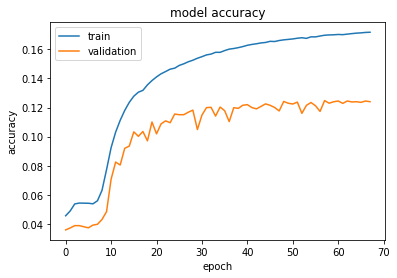

In [53]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

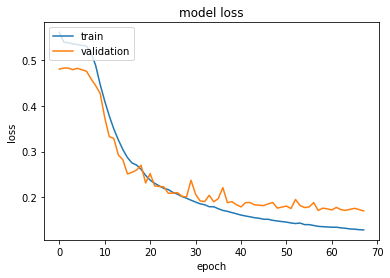

In [54]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [56]:
%ls -ltr

total 237215
-rw------- 1 root root   3898148 Sep 14 19:57 affidavits.csv
-rw------- 1 root root    813709 Sep 14 22:38 players_with_hindi_names.json
-rw------- 1 root root   6128992 Sep 19 21:17 model_v1.h5
-rw------- 1 root root   1326377 Sep 20 22:52 hi.translit.sampled.train.tsv
-rw------- 1 root root     54982 Sep 24 18:31 model_plot_dec.png
-rw------- 1 root root     70405 Sep 27 15:25 model.png
-rw------- 1 root root    282545 Sep 27 23:55 Transliterate_v2.ipynb
-rw------- 1 root root 230330576 Sep 28 03:25 model.h5


In [57]:
!du -sh model.h5

220M	model.h5


# Inference

In [61]:
# Restore the model and construct the encoder and decoder.
model = load_model(model_save_filename, custom_objects={"CERMetric": CERMetric})
# model = load_model("model_v1.h5")

In [62]:
# Predictions
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_inputs_em = decoder_embedding(decoder_inputs)

# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[7] # lstm_2
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs_re, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[-1]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

(None, None, 8960)


In [63]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

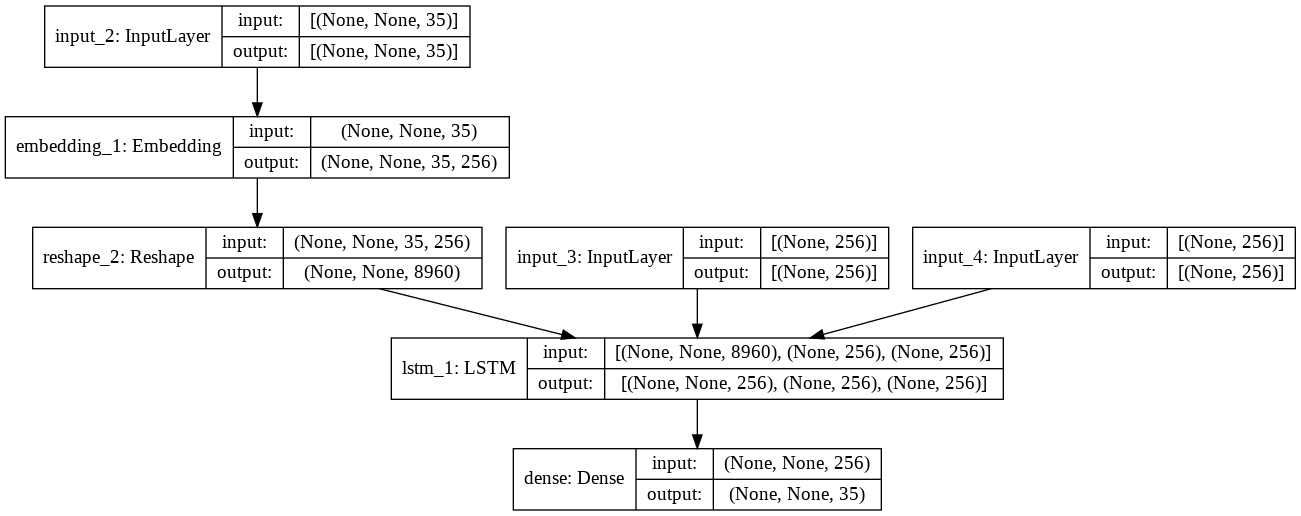

In [64]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [65]:
def predict_target(input_string):
  # convert for encoding 
  input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
  for t, char in enumerate(input_string):
    input_data[0, t, input_token_index[char]] = 1.

  # Encode the input as state vectors.
  states_value = encoder_model(input_data)

   # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index['^']] = 1.0

  stop_condition = False
  decoded_sentence = ""

  while True:
    output_tokens, d_h, d_c = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    # Exit condition: either hit max length
    # or find stop character.
    if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
      break
      
    decoded_sentence += sampled_char

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [d_h, d_c]
  return decoded_sentence

In [66]:
test_input = 'राजशेखर'
predicted_string = predict_target(test_input)
predicted_string

'rajasekhar'

In [67]:
test_input = 'गौरव'
predicted_string = predict_target(test_input)
predicted_string

'gaurav'

In [68]:
test_input = 'सूद'
predicted_string = predict_target(test_input)
predicted_string

'suda'